In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import label_binarize, LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from scipy.stats import zscore

In [2]:
inventory_df = pd.read_excel('Proceco_IM (1).xlsx')

In [3]:
inventory_df.head()

,IM_KEY,IM_DESCR,IM_BUYER,IM_ABC,IM_TYPE,IM_CLASS,IM_STOCK_SW,IM_QTY,IM_POLICY,IM_C_RECV,...,IM_COST,IM_COST_CONV,IM_COST_UM,IM_DAYS,IM_GL_ACCT,IM_LAST_REC_DATE,IM_LY_REC_YTD,IM_LY_USAGE,IM_SAFETY,IM_USAGE
0,SCA042A,"RESSORT TENS. 0.62""ODx3.5LG SS",STE,,2,1,1,0,1,1.0,...,11.5869,1,NaN,0,120,2005-06-13,0,0,0,0
1,PLN060F,M6x1.0x12MM VIS TETE FR. SS304,GY,,2,1,1,0,1,1.0,...,0.4626,1,NaN,0,120,2022-07-18,0,0,0,0
2,QTK022C,RACC Y 1/4 TUBE,STE,,2,1,1,0,1,1.0,...,1.6089,1,NaN,0,120,2002-06-27,0,0,0,0
3,PMJ056I,1/2x1-1/2LG VIS EPAULEMENT SS,GY,,2,1,1,0,1,1.0,...,11.1849,1,NaN,0,120,2015-10-01,0,0,0,0
4,GKR710A,CARTOUCHE 8135 POLY-E 10 MICR.,GY,,2,1,1,0,1,1.0,...,736.6892,1,NaN,0,120,2023-10-19,0,0,0,1


In [4]:
column_names = inventory_df.columns.tolist()
print(column_names)

['IM_KEY', 'IM_DESCR', 'IM_BUYER', 'IM_ABC', 'IM_TYPE', 'IM_CLASS', 'IM_STOCK_SW', 'IM_QTY', 'IM_POLICY', 'IM_C_RECV', 'IM_LEADTIME', 'IM_MIN', 'IM_MAX', 'IM_ON_HAND', 'IM_HOLD', 'IM_UNIT_I', 'IM_UNIT_R', 'IM_UNIT_S', 'IM_STD_MAT', 'IM_COST', 'IM_COST_CONV', 'IM_COST_UM', 'IM_DAYS', 'IM_GL_ACCT', 'IM_LAST_REC_DATE', 'IM_LY_REC_YTD', 'IM_LY_USAGE', 'IM_SAFETY', 'IM_USAGE']


In [5]:
inventory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4256 entries, 0 to 4255
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   IM_KEY            4256 non-null   object        
 1   IM_DESCR          4256 non-null   object        
 2   IM_BUYER          4256 non-null   object        
 3   IM_ABC            4256 non-null   object        
 4   IM_TYPE           4256 non-null   int64         
 5   IM_CLASS          4256 non-null   int64         
 6   IM_STOCK_SW       4256 non-null   int64         
 7   IM_QTY            4256 non-null   int64         
 8   IM_POLICY         4256 non-null   int64         
 9   IM_C_RECV         4256 non-null   float64       
 10  IM_LEADTIME       4256 non-null   int64         
 11  IM_MIN            4256 non-null   int64         
 12  IM_MAX            4256 non-null   int64         
 13  IM_ON_HAND        4256 non-null   int64         
 14  IM_HOLD           4256 n

In [6]:
# Calculate the number of unique values and the percentage of missing values for each column
unique_counts = inventory_df.nunique()
missing_percentage = inventory_df.isnull().mean() * 100

# Identify constant columns and columns with a high percentage of missing values
constant_columns = unique_counts[unique_counts <= 1].index.tolist()
high_missing_columns = missing_percentage[missing_percentage > 50].index.tolist()  # Threshold at 50%, can be adjusted

# Combine the lists while ensuring uniqueness
columns_to_consider_dropping = list(set(constant_columns + high_missing_columns))

# Display the columns
columns_to_consider_dropping

['IM_COST_CONV', 'IM_DAYS', 'IM_COST_UM', 'IM_GL_ACCT', 'IM_HOLD', 'IM_POLICY']

In [7]:
inventory_df = inventory_df.drop_duplicates()

In [8]:
inventory_df.fillna({'IM_COST_UM': 0}, inplace=True)

inventory_df['IM_LAST_REC_DATE'] = pd.to_datetime(inventory_df['IM_LAST_REC_DATE'])

inventory_df['IM_DESCR'] = inventory_df['IM_DESCR'].str.strip().str.upper()

In [9]:
inventory_df = inventory_df[inventory_df['IM_LAST_REC_DATE'].dt.year >= 2018]

# Display the first few rows of the filtered DataFrame to verify
inventory_df.head()

,IM_KEY,IM_DESCR,IM_BUYER,IM_ABC,IM_TYPE,IM_CLASS,IM_STOCK_SW,IM_QTY,IM_POLICY,IM_C_RECV,...,IM_COST,IM_COST_CONV,IM_COST_UM,IM_DAYS,IM_GL_ACCT,IM_LAST_REC_DATE,IM_LY_REC_YTD,IM_LY_USAGE,IM_SAFETY,IM_USAGE
1,PLN060F,M6X1.0X12MM VIS TETE FR. SS304,GY,,2,1,1,0,1,1.000000,...,0.4626,1,0,0,120,2022-07-18,0,0,0,0
4,GKR710A,CARTOUCHE 8135 POLY-E 10 MICR.,GY,,2,1,1,0,1,1.000000,...,736.6892,1,0,0,120,2023-10-19,0,0,0,1
7,SKA000X,"CYL. AMORT. GAZ 8"" - 80 #",STE,A,2,1,1,0,1,1.000000,...,48.2432,1,0,0,120,2024-01-24,0,0,0,20
8,NEE120A,1-1/2 TUYAU SS304L SCH 10,GY,A,2,1,1,0,1,0.083333,...,0.7736,1,0,0,120,2023-11-29,0,0,0,2195
9,FCF217E,"PIGNON SIMPLE 17DXRC40X1-3/8""",STE,B,2,1,1,0,1,1.000000,...,4.0596,1,0,0,120,2023-11-13,0,0,0,14


In [10]:
inventory_df.describe()

,IM_TYPE,IM_CLASS,IM_STOCK_SW,IM_QTY,IM_POLICY,IM_C_RECV,IM_LEADTIME,IM_MIN,IM_MAX,IM_ON_HAND,IM_HOLD,IM_STD_MAT,IM_COST,IM_COST_CONV,IM_DAYS,IM_GL_ACCT,IM_LY_REC_YTD,IM_LY_USAGE,IM_SAFETY,IM_USAGE
count,3369.000000,3369.000000,3369.000000,3369.000000,3369.0,3369.000000,3369.000000,3369.000000,3369.000000,3.369000e+03,3369.0,3369.000000,3369.000000,3369.0,3369.0,3369.0,3369.000000,3369.000000,3369.000000,3.369000e+03
mean,1.977145,1.042743,0.963491,0.149896,1.0,0.851788,14.159988,2.082517,4.980113,1.058746e+03,0.0,53.705647,129.477562,1.0,0.0,120.0,0.710597,1.244286,0.030276,2.820074e+03
std,0.149465,0.363836,0.187582,8.614695,0.0,0.676240,17.858882,29.669023,59.399428,2.527050e+04,0.0,235.920396,2465.366751,0.0,0.0,0.0,41.348868,62.838504,1.723020,4.858180e+04
min,1.000000,1.000000,0.000000,0.000000,1.0,0.001389,0.000000,0.000000,0.000000,1.000000e+00,0.0,0.000000,0.002000,1.0,0.0,120.0,-8.000000,-840.000000,0.000000,-2.160000e+03
25%,2.000000,1.000000,1.000000,0.000000,1.0,0.998089,5.000000,0.000000,0.000000,3.000000e+00,0.0,0.725100,0.836400,1.0,0.0,120.0,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,1.000000,1.000000,0.000000,1.0,1.000000,10.000000,0.000000,0.000000,8.000000e+00,0.0,3.817000,4.283700,1.0,0.0,120.0,0.000000,0.000000,0.000000,6.000000e+00
75%,2.000000,1.000000,1.000000,0.000000,1.0,1.000000,15.000000,0.000000,0.000000,7.400000e+01,0.0,20.107300,22.397300,1.0,0.0,120.0,0.000000,0.000000,0.000000,4.500000e+01
max,2.000000,9.000000,1.000000,500.000000,1.0,14.258333,240.000000,1369.000000,2151.000000,1.394778e+06,0.0,4716.530000,115049.110000,1.0,0.0,120.0,2400.000000,2615.000000,100.000000,1.566106e+06


In [11]:
inventory_df.shape

(3369, 29)

In [12]:
inventory_df.isnull().sum()

IM_KEY              0
IM_DESCR            0
IM_BUYER            0
IM_ABC              0
IM_TYPE             0
IM_CLASS            0
IM_STOCK_SW         0
IM_QTY              0
IM_POLICY           0
IM_C_RECV           0
IM_LEADTIME         0
IM_MIN              0
IM_MAX              0
IM_ON_HAND          0
IM_HOLD             0
IM_UNIT_I           0
IM_UNIT_R           0
IM_UNIT_S           0
IM_STD_MAT          0
IM_COST             0
IM_COST_CONV        0
IM_COST_UM          0
IM_DAYS             0
IM_GL_ACCT          0
IM_LAST_REC_DATE    0
IM_LY_REC_YTD       0
IM_LY_USAGE         0
IM_SAFETY           0
IM_USAGE            0
dtype: int64

In [13]:
columns_to_drop = ['IM_GL_ACCT', 'IM_HOLD', 'IM_DAYS','IM_POLICY', 'IM_C_RECV', 'IM_COST_CONV', 'IM_LY_REC_YTD', 'IM_LY_USAGE', 'IM_USAGE', 'IM_STOCK_SW', 'IM_COST_UM']
inventory_df.drop(columns=columns_to_drop, axis=1, inplace=True)

inventory_df.head()

,IM_KEY,IM_DESCR,IM_BUYER,IM_ABC,IM_TYPE,IM_CLASS,IM_QTY,IM_LEADTIME,IM_MIN,IM_MAX,IM_ON_HAND,IM_UNIT_I,IM_UNIT_R,IM_UNIT_S,IM_STD_MAT,IM_COST,IM_LAST_REC_DATE,IM_SAFETY
1,PLN060F,M6X1.0X12MM VIS TETE FR. SS304,GY,,2,1,0,10,0,0,8,EA,EA,EA,0.4626,0.4626,2022-07-18,0
4,GKR710A,CARTOUCHE 8135 POLY-E 10 MICR.,GY,,2,1,0,10,0,0,1,EA,EA,EA,736.6892,736.6892,2023-10-19,0
7,SKA000X,"CYL. AMORT. GAZ 8"" - 80 #",STE,A,2,1,0,10,0,0,8,EA,EA,EA,48.2432,48.2432,2024-01-24,0
8,NEE120A,1-1/2 TUYAU SS304L SCH 10,GY,A,2,1,0,10,0,0,138,IN,FT,IN,0.7736,0.7736,2023-11-29,0
9,FCF217E,"PIGNON SIMPLE 17DXRC40X1-3/8""",STE,B,2,1,0,10,0,0,4,EA,EA,EA,4.0596,4.0596,2023-11-13,0


In [14]:
# Count the number of unique values in the 'IM_ABC' column
num_unique_values_im_abc = inventory_df['IM_ABC'].unique()

num_unique_values_im_abc

array([' ', 'A', 'B', 'C'], dtype=object)

In [15]:
# Define the values to look for
values_to_check = ['A', 'B', 'C']

# Count the number of rows where 'IM_ABC' is 'A', 'B', 'C'
rows_with_abc_or_d = inventory_df['IM_ABC'].isin(values_to_check).sum()

rows_with_abc_or_d


1772

In [16]:
# Create a DataFrame with rows where 'IM_ABC' is 'A', 'B', 'C', or 'D'
abc_filtered_df = inventory_df[inventory_df['IM_ABC'].isin(['A', 'B', 'C', 'D'])]

# Display the first few rows of the abc_filtered_df DataFrame to verify
abc_filtered_df.head()


,IM_KEY,IM_DESCR,IM_BUYER,IM_ABC,IM_TYPE,IM_CLASS,IM_QTY,IM_LEADTIME,IM_MIN,IM_MAX,IM_ON_HAND,IM_UNIT_I,IM_UNIT_R,IM_UNIT_S,IM_STD_MAT,IM_COST,IM_LAST_REC_DATE,IM_SAFETY
7,SKA000X,"CYL. AMORT. GAZ 8"" - 80 #",STE,A,2,1,0,10,0,0,8,EA,EA,EA,48.2432,48.2432,2024-01-24,0
8,NEE120A,1-1/2 TUYAU SS304L SCH 10,GY,A,2,1,0,10,0,0,138,IN,FT,IN,0.7736,0.7736,2023-11-29,0
9,FCF217E,"PIGNON SIMPLE 17DXRC40X1-3/8""",STE,B,2,1,0,10,0,0,4,EA,EA,EA,4.0596,4.0596,2023-11-13,0
11,RMW016B,PLAQUE DE BOUT,STE,C,2,1,0,5,1,2,2,EA,EA,EA,0.5807,0.5807,2018-04-24,0
16,RKK204G,CABLE BLINDE 4 COND. 2.5MM,STE,A,2,1,0,20,0,0,178,FT,M,FT,3.4571,3.4571,2023-11-02,0


In [17]:
abc_filtered_df = abc_filtered_df.reset_index(drop=True, inplace=False)

To account for the sensitivity of classification models, particularly K-Nearest Neighbors (KNN), to large numerical values, I normalized data.

In [18]:

numeric_features = abc_filtered_df.select_dtypes(include=['int64', 'float64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the numeric features and transform them
abc_filtered_df[numeric_features] = scaler.fit_transform(abc_filtered_df[numeric_features])

# Display the first few rows to verify the normalization
abc_filtered_df.head()


,IM_KEY,IM_DESCR,IM_BUYER,IM_ABC,IM_TYPE,IM_CLASS,IM_QTY,IM_LEADTIME,IM_MIN,IM_MAX,IM_ON_HAND,IM_UNIT_I,IM_UNIT_R,IM_UNIT_S,IM_STD_MAT,IM_COST,IM_LAST_REC_DATE,IM_SAFETY
0,SKA000X,"CYL. AMORT. GAZ 8"" - 80 #",STE,A,1.0,0.0,0.0,0.041667,0.00000,0.00000,5.018723e-06,EA,EA,EA,0.012066,0.012066,2024-01-24,0.0
1,NEE120A,1-1/2 TUYAU SS304L SCH 10,GY,A,1.0,0.0,0.0,0.041667,0.00000,0.00000,9.822359e-05,IN,FT,IN,0.000193,0.000193,2023-11-29,0.0
2,FCF217E,"PIGNON SIMPLE 17DXRC40X1-3/8""",STE,B,1.0,0.0,0.0,0.041667,0.00000,0.00000,2.150881e-06,EA,EA,EA,0.001015,0.001015,2023-11-13,0.0
3,RMW016B,PLAQUE DE BOUT,STE,C,1.0,0.0,0.0,0.020833,0.00073,0.00093,7.169605e-07,EA,EA,EA,0.000145,0.000145,2018-04-24,0.0
4,RKK204G,CABLE BLINDE 4 COND. 2.5MM,STE,A,1.0,0.0,0.0,0.083333,0.00000,0.00000,1.269020e-04,FT,M,FT,0.000865,0.000864,2023-11-02,0.0


In [19]:
# Apply zscore to all numeric columns in the DataFrame
z_scores = abc_filtered_df[numeric_features].apply(zscore)

# Create a mask for rows with all z-scores within the desired range
mask = (z_scores > -3) & (z_scores < 3)

# Apply the mask to the DataFrame to filter out outliers
abc_filtered_df_cleaned = abc_filtered_df[mask.all(axis=1)]

# Display the first few rows to verify the removal of outliers
abc_filtered_df_cleaned.head()


,IM_KEY,IM_DESCR,IM_BUYER,IM_ABC,IM_TYPE,IM_CLASS,IM_QTY,IM_LEADTIME,IM_MIN,IM_MAX,IM_ON_HAND,IM_UNIT_I,IM_UNIT_R,IM_UNIT_S,IM_STD_MAT,IM_COST,IM_LAST_REC_DATE,IM_SAFETY
0,SKA000X,"CYL. AMORT. GAZ 8"" - 80 #",STE,A,1.0,0.0,0.0,0.041667,0.00000,0.00000,5.018723e-06,EA,EA,EA,0.012066,0.012066,2024-01-24,0.0
1,NEE120A,1-1/2 TUYAU SS304L SCH 10,GY,A,1.0,0.0,0.0,0.041667,0.00000,0.00000,9.822359e-05,IN,FT,IN,0.000193,0.000193,2023-11-29,0.0
2,FCF217E,"PIGNON SIMPLE 17DXRC40X1-3/8""",STE,B,1.0,0.0,0.0,0.041667,0.00000,0.00000,2.150881e-06,EA,EA,EA,0.001015,0.001015,2023-11-13,0.0
3,RMW016B,PLAQUE DE BOUT,STE,C,1.0,0.0,0.0,0.020833,0.00073,0.00093,7.169605e-07,EA,EA,EA,0.000145,0.000145,2018-04-24,0.0
4,RKK204G,CABLE BLINDE 4 COND. 2.5MM,STE,A,1.0,0.0,0.0,0.083333,0.00000,0.00000,1.269020e-04,FT,M,FT,0.000865,0.000864,2023-11-02,0.0


In [20]:
# Reset index and drop old index
# Create a new DataFrame with the reset index
abc_filtered_df_cleaned = abc_filtered_df_cleaned.reset_index(drop=True, inplace=False)


In [21]:
abc_filtered_df_cleaned

,IM_KEY,IM_DESCR,IM_BUYER,IM_ABC,IM_TYPE,IM_CLASS,IM_QTY,IM_LEADTIME,IM_MIN,IM_MAX,IM_ON_HAND,IM_UNIT_I,IM_UNIT_R,IM_UNIT_S,IM_STD_MAT,IM_COST,IM_LAST_REC_DATE,IM_SAFETY
0,SKA000X,"CYL. AMORT. GAZ 8"" - 80 #",STE,A,1.0,0.0,0.0,0.041667,0.000000,0.000000,5.018723e-06,EA,EA,EA,0.012066,0.012066,2024-01-24,0.0
1,NEE120A,1-1/2 TUYAU SS304L SCH 10,GY,A,1.0,0.0,0.0,0.041667,0.000000,0.000000,9.822359e-05,IN,FT,IN,0.000193,0.000193,2023-11-29,0.0
2,FCF217E,"PIGNON SIMPLE 17DXRC40X1-3/8""",STE,B,1.0,0.0,0.0,0.041667,0.000000,0.000000,2.150881e-06,EA,EA,EA,0.001015,0.001015,2023-11-13,0.0
3,RMW016B,PLAQUE DE BOUT,STE,C,1.0,0.0,0.0,0.020833,0.000730,0.000930,7.169605e-07,EA,EA,EA,0.000145,0.000145,2018-04-24,0.0
4,RKK204G,CABLE BLINDE 4 COND. 2.5MM,STE,A,1.0,0.0,0.0,0.083333,0.000000,0.000000,1.269020e-04,FT,M,FT,0.000865,0.000864,2023-11-02,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,SFZ045B,"MADRIER ÉPINETTE 2""X4""X16'",STE,A,1.0,0.0,0.0,0.020833,0.000000,0.000000,1.935793e-05,EA,EA,EA,0.002024,0.002023,2023-12-05,0.0
1646,EAW060A,ECROU DE MONTAGE 60MM,STE,B,1.0,0.0,0.0,0.062500,0.000000,0.000000,7.169605e-07,EA,EA,EA,0.001516,0.001515,2023-11-27,0.0
1647,NHE120R,1-1/2 BRIDE WELD-NECK SS 10,GY,C,1.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000e+00,EA,EA,EA,0.006276,0.006275,2023-04-26,0.0
1648,EAV030F,"JOINT METAL.,30MM, 6206-AV-SS",STE,C,1.0,0.0,0.0,0.083333,0.000000,0.000000,7.169605e-07,EA,EA,EA,0.002153,0.002153,2024-01-09,0.0


In [22]:
abc_filtered_df_cleaned.shape

(1650, 18)

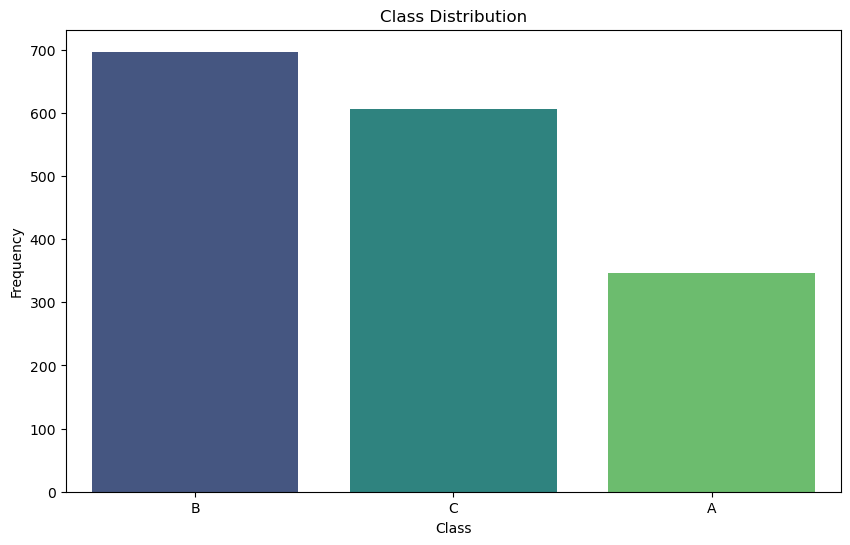

In [23]:


# Assuming your target variable is named 'Target' and it's a column in abc_filtered_df
# Replace 'Target' with your actual target column name
class_counts = abc_filtered_df_cleaned['IM_ABC'].value_counts()

# Plotting the class distribution as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


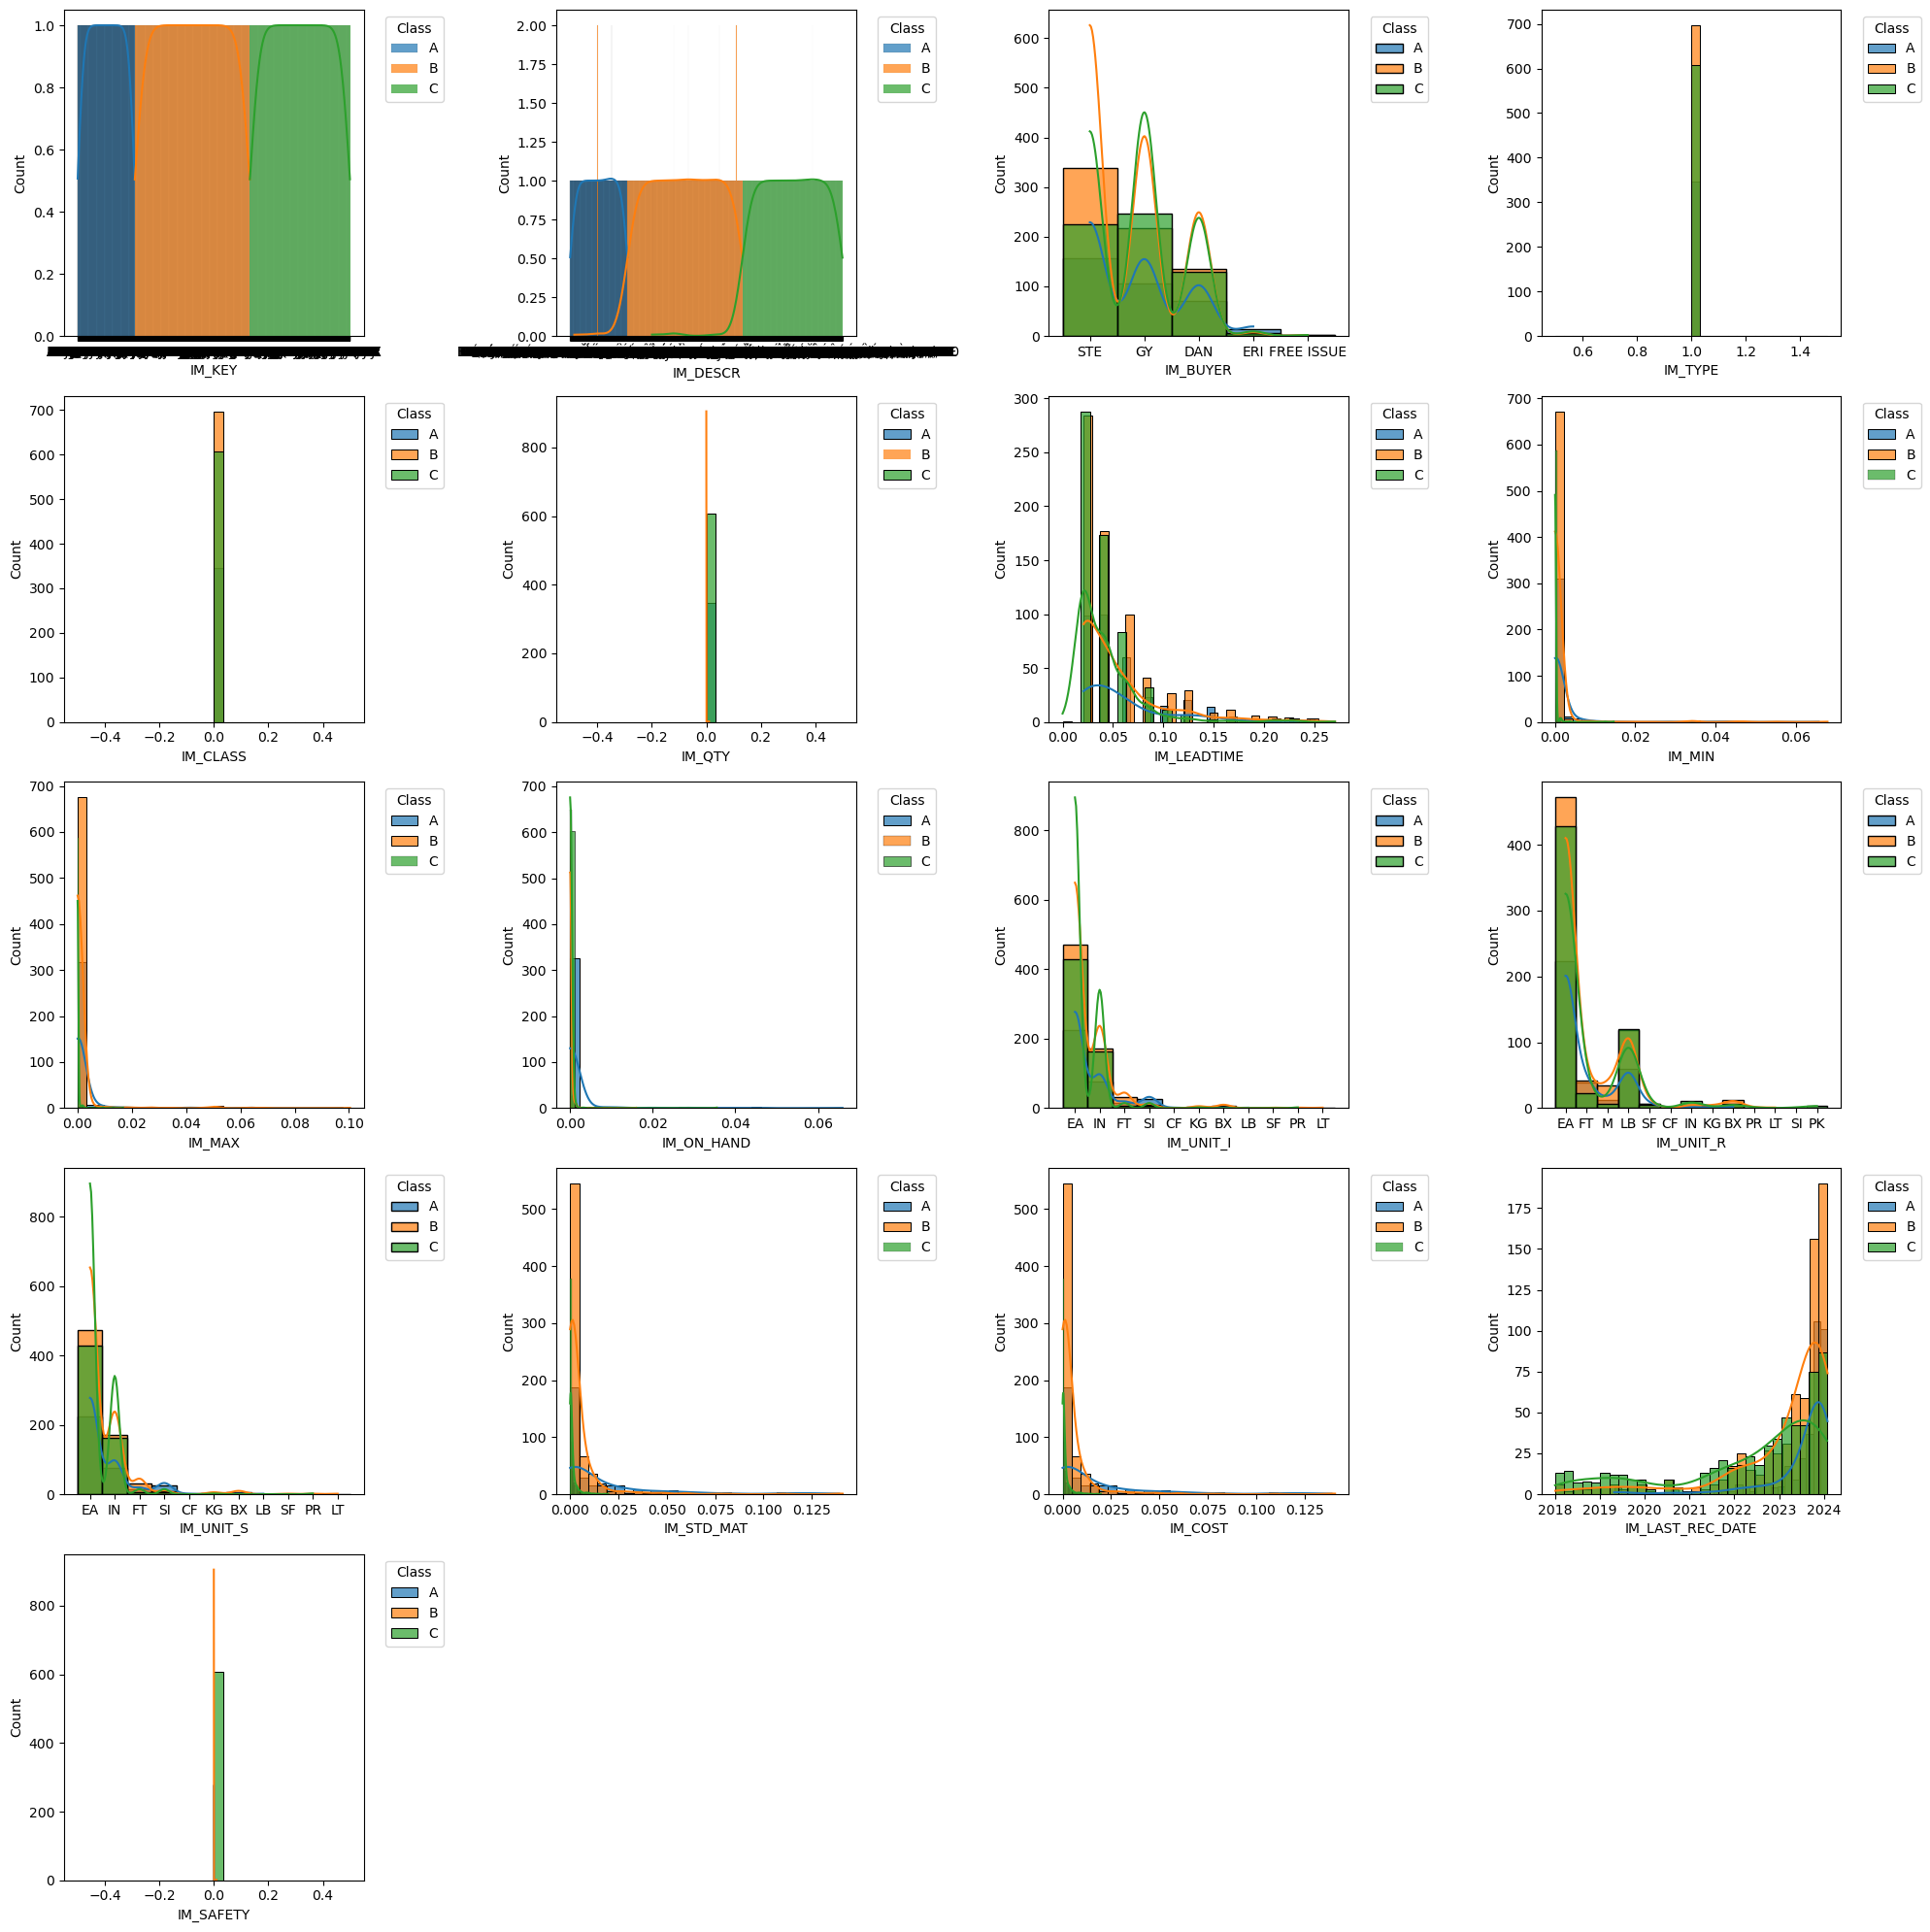

In [24]:
num_columns = len(abc_filtered_df_cleaned.columns) - 1  # Exclude the 'Class' column
num_rows = math.ceil(num_columns / 4)  # Adjust the number of columns per row if needed

plt.figure(figsize=(20, 4 * num_rows))  # Adjust the figure size dynamically based on the number of rows

for idx, column in enumerate(abc_filtered_df_cleaned.drop('IM_ABC', axis=1).columns):  # Exclude the 'Class' column from plotting
    plt.subplot(num_rows, 4, idx + 1)  # Adjust the number of columns per row if needed
    for class_label in abc_filtered_df_cleaned['IM_ABC'].unique():
        subset_data = abc_filtered_df_cleaned[abc_filtered_df_cleaned['IM_ABC'] == class_label]
        sns.histplot(data=subset_data, x=column, bins=30, label=class_label, alpha=0.7, kde=True)  # Added KDE for smoother distribution visualization
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


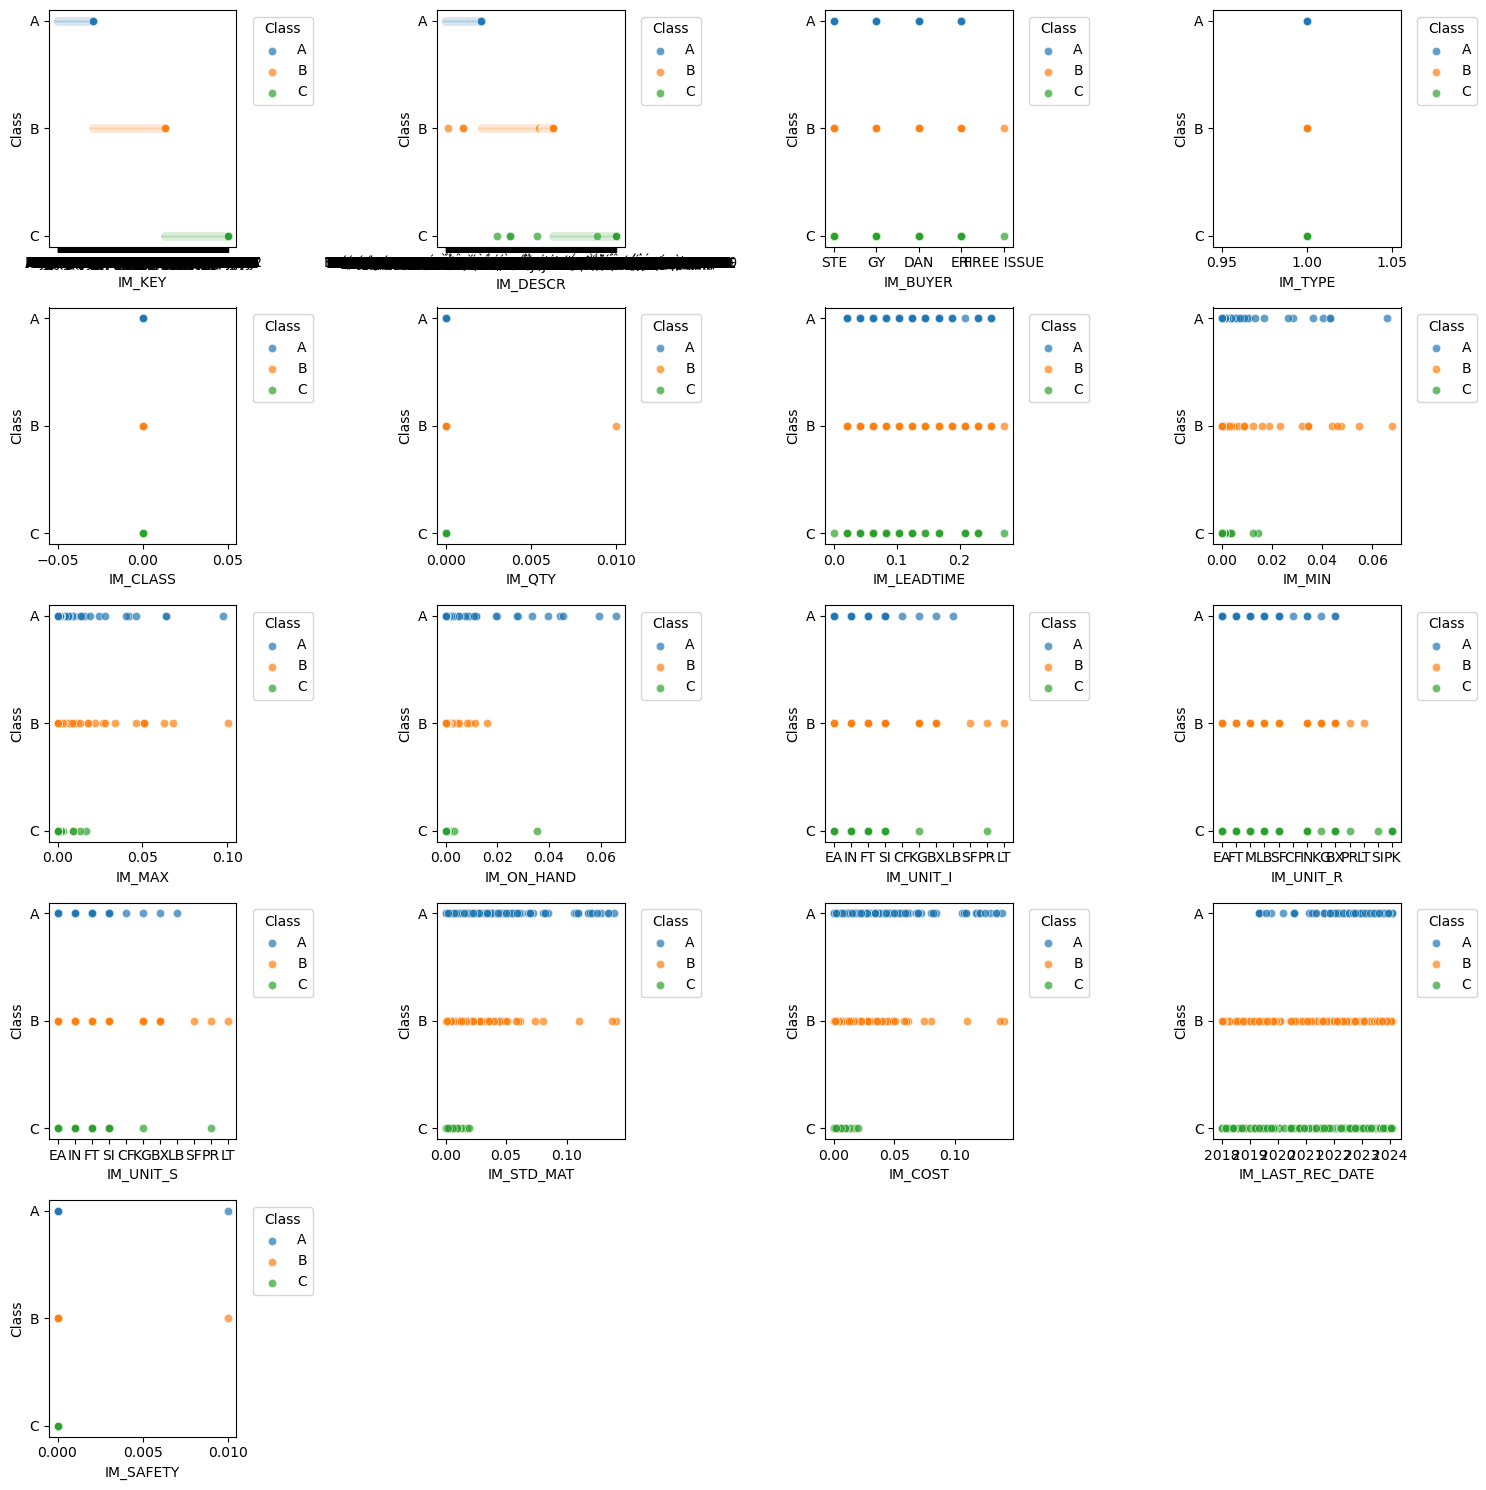

In [25]:
plt.figure(figsize=(15, 15))

# Iterate over each column, excluding the 'Class' column
for idx, column in enumerate(abc_filtered_df_cleaned.drop('IM_ABC', axis=1).columns):
    plt.subplot(5, 4, idx + 1)  # Adjust subplot dimensions as needed
    for class_label in abc_filtered_df_cleaned['IM_ABC'].unique():
        # Filter data for each class
        subset_data = abc_filtered_df_cleaned[abc_filtered_df_cleaned['IM_ABC'] == class_label]
        # Create scatter plots
        sns.scatterplot(data=subset_data, x=column, y='IM_ABC', label=class_label, alpha=0.7)
    plt.xlabel(column)
    plt.ylabel('Class')
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [26]:
# Identify columns with data type 'object' or 'category'
categorical_columns = abc_filtered_df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()

# Additionally, check for numerical columns with a limited number of unique values
for col in abc_filtered_df_cleaned.select_dtypes(include=['int64', 'float64']):
    if abc_filtered_df_cleaned[col].nunique() < 10:  # Arbitrary threshold, adjust based on domain knowledge
        categorical_columns.append(col)

# Display the list of categorical columns
categorical_columns


['IM_KEY',
 'IM_DESCR',
 'IM_BUYER',
 'IM_ABC',
 'IM_UNIT_I',
 'IM_UNIT_R',
 'IM_UNIT_S',
 'IM_TYPE',
 'IM_CLASS',
 'IM_QTY',
 'IM_SAFETY']

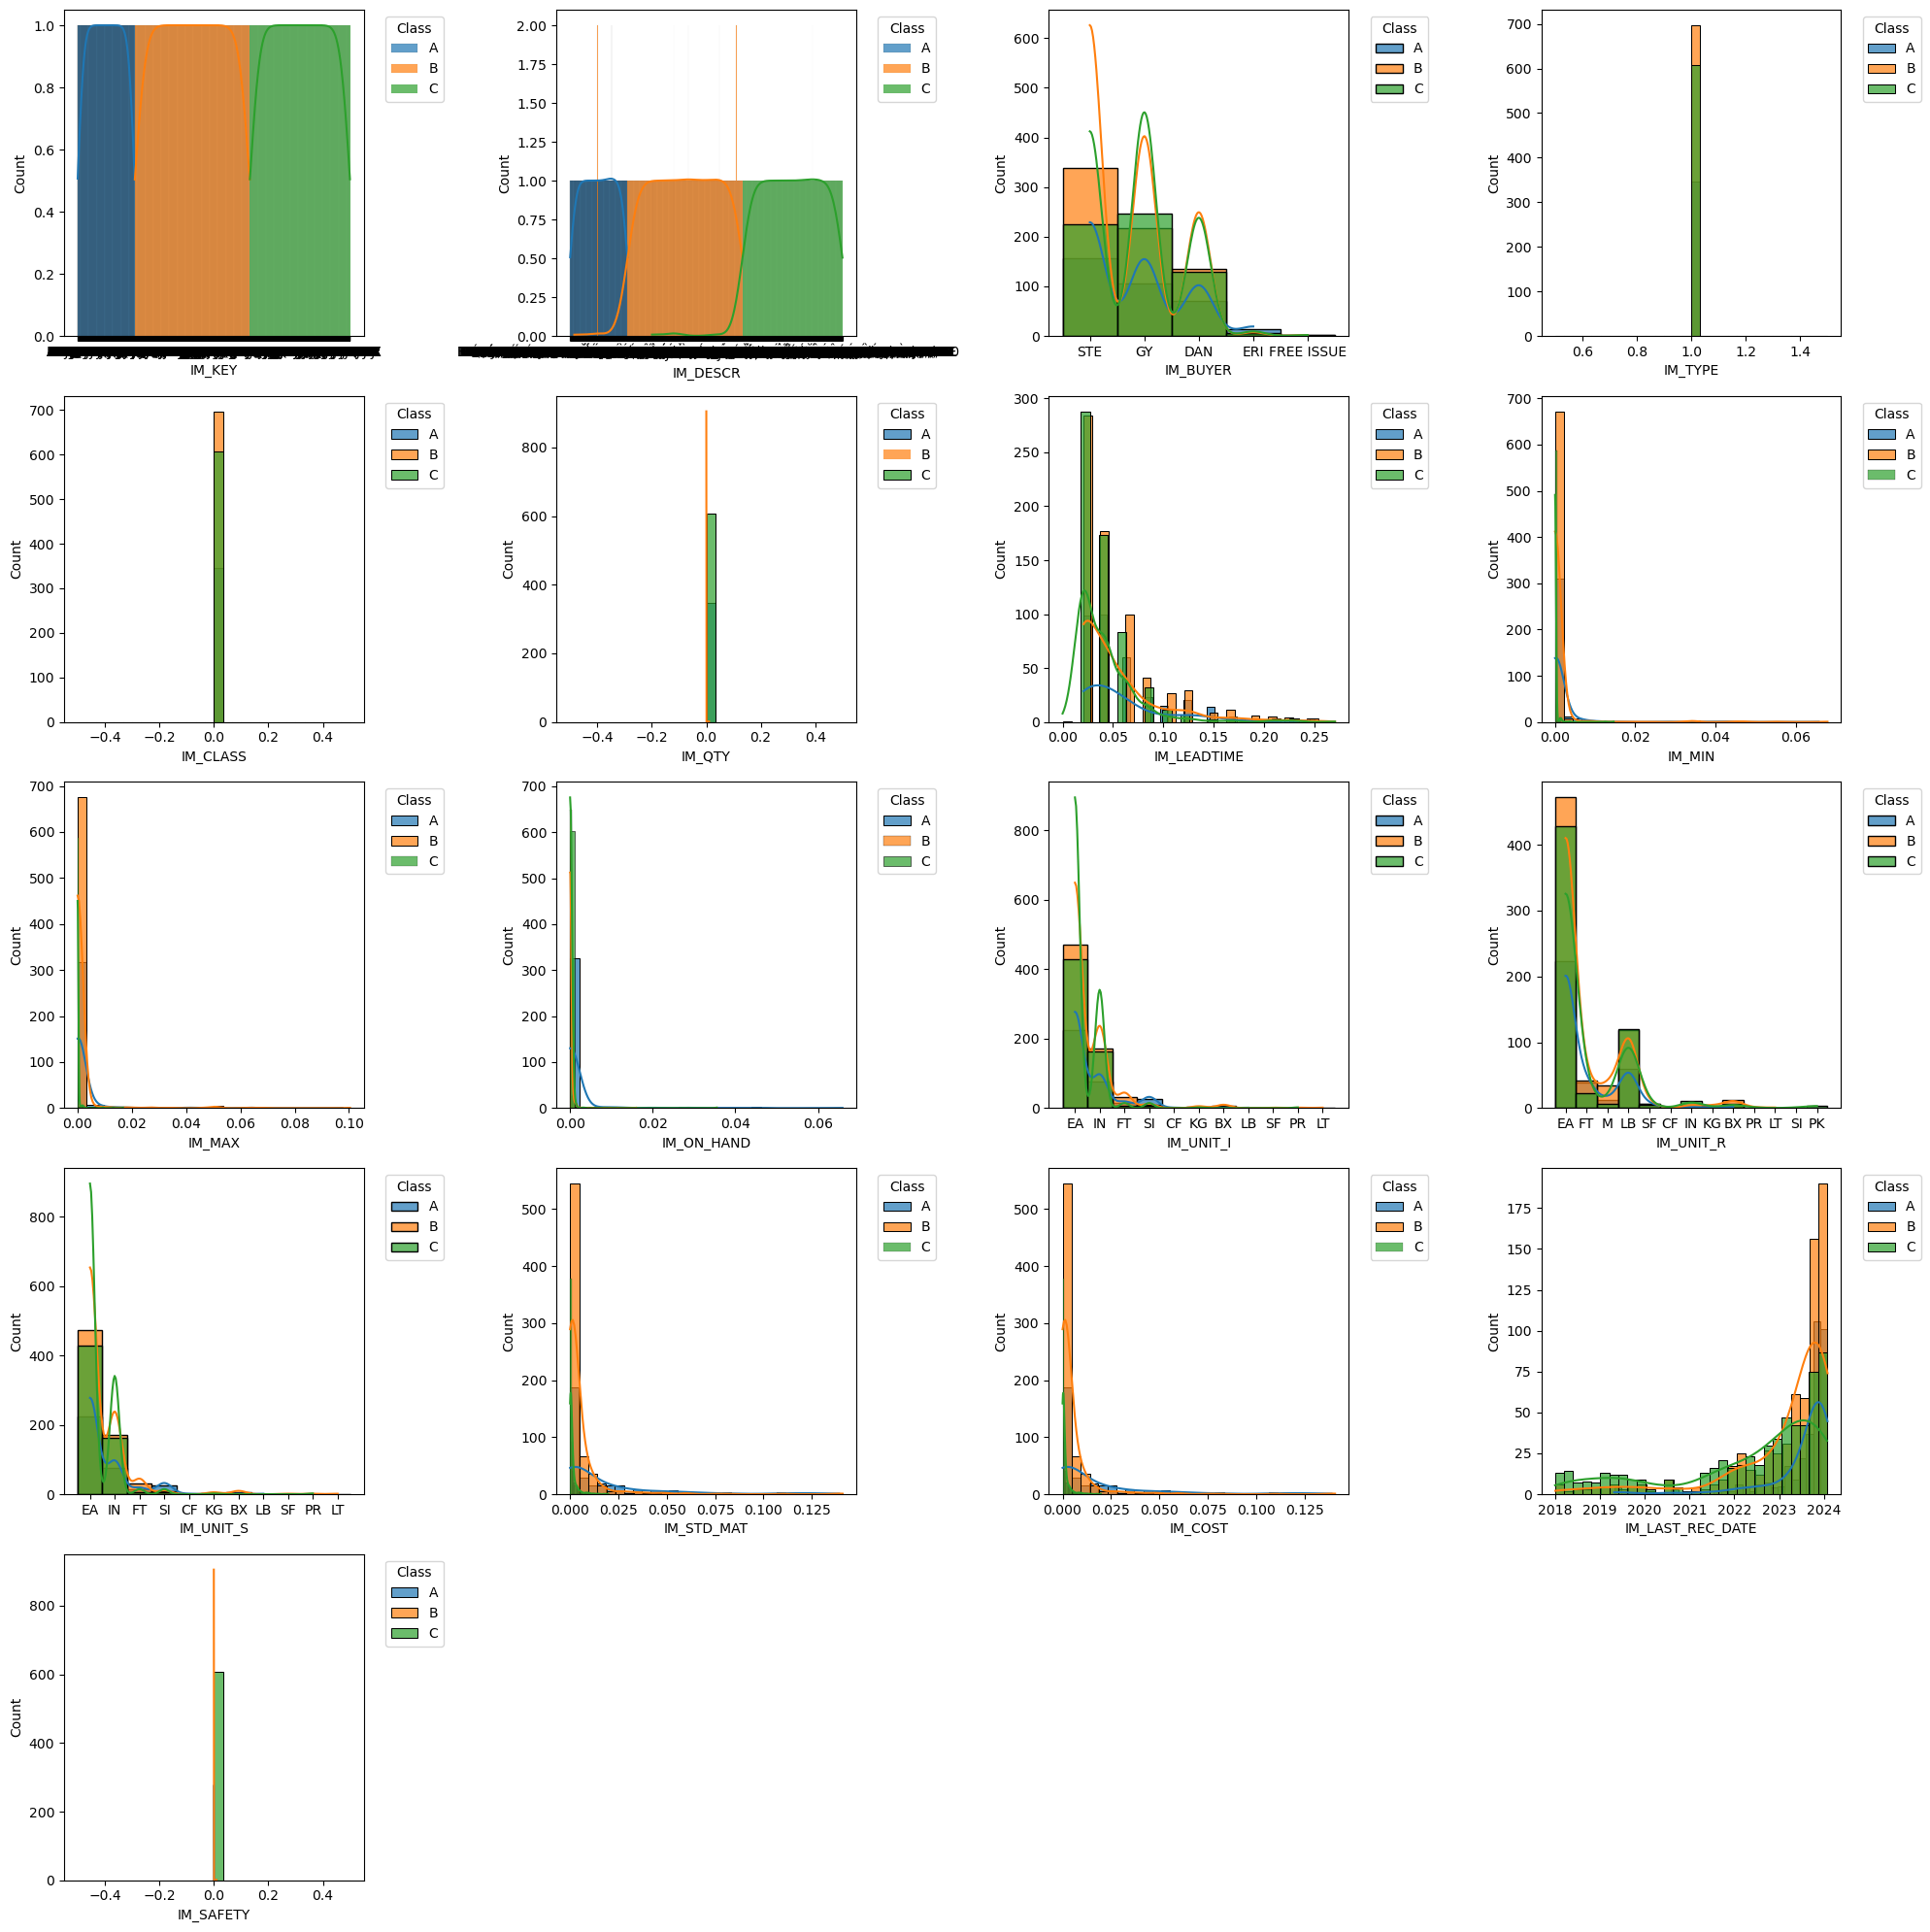

In [27]:
# Assuming 'IM_ABC' is still in your cleaned DataFrame, adjust if it's named differently
class_column = 'IM_ABC'

# Calculate the number of rows needed for subplots based on the number of columns in the cleaned DataFrame
num_columns_cleaned = len(abc_filtered_df_cleaned.columns) - 1  # Exclude the class column
num_rows_cleaned = math.ceil(num_columns_cleaned / 4)  # Adjust the number of columns per row if needed

plt.figure(figsize=(20, 4 * num_rows_cleaned))  # Adjust the figure size dynamically based on the number of rows

for idx, column in enumerate(abc_filtered_df_cleaned.drop(class_column, axis=1).columns):
    plt.subplot(num_rows_cleaned, 4, idx + 1)  # Adjust the number of columns per row if needed
    for class_label in abc_filtered_df_cleaned[class_column].unique():
        subset_data = abc_filtered_df_cleaned[abc_filtered_df_cleaned[class_column] == class_label]
        sns.histplot(data=subset_data, x=column, bins=30, label=class_label, alpha=0.7, kde=True)  # KDE for smoother distribution
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [28]:
# Define the columns to exclude from the features
exclude_columns = [
    'IM_KEY', 'IM_DESCR', 'IM_BUYER', "IM_LAST_REC_DATE",
    'IM_UNIT_I', 'IM_UNIT_R', 'IM_UNIT_S', 'IM_TYPE',
    'IM_CLASS', 'IM_QTY', 'IM_SAFETY'
]

# Prepare the features (X) by excluding the specified columns and the target (y) as 'IM_ABC'
X = abc_filtered_df.drop(columns=exclude_columns + ['IM_ABC'])
y = abc_filtered_df['IM_ABC']

In [29]:
X

,IM_LEADTIME,IM_MIN,IM_MAX,IM_ON_HAND,IM_STD_MAT,IM_COST
0,0.041667,0.000000,0.000000,5.018723e-06,0.012066,0.012066
1,0.041667,0.000000,0.000000,9.822359e-05,0.000193,0.000193
2,0.041667,0.000000,0.000000,2.150881e-06,0.001015,0.001015
3,0.020833,0.000730,0.000930,7.169605e-07,0.000145,0.000145
4,0.083333,0.000000,0.000000,1.269020e-04,0.000865,0.000864
...,...,...,...,...,...,...
1767,0.020833,0.000000,0.000000,1.935793e-05,0.002024,0.002023
1768,0.062500,0.000000,0.000000,7.169605e-07,0.001516,0.001515
1769,0.041667,0.000000,0.000000,0.000000e+00,0.006276,0.006275
1770,0.083333,0.000000,0.000000,7.169605e-07,0.002153,0.002153


In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Ensure the data is contiguous in memory
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

In [31]:
# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Make predictions
predictions_first_model = knn.predict(X_test)

Model Performance Metrics:
Accuracy: 0.51
Precision: 0.54
Recall: 0.51
F1 Score: 0.51
Confusion Matrix:
[[38 37 15]
 [17 72 59]
 [ 3 43 71]]


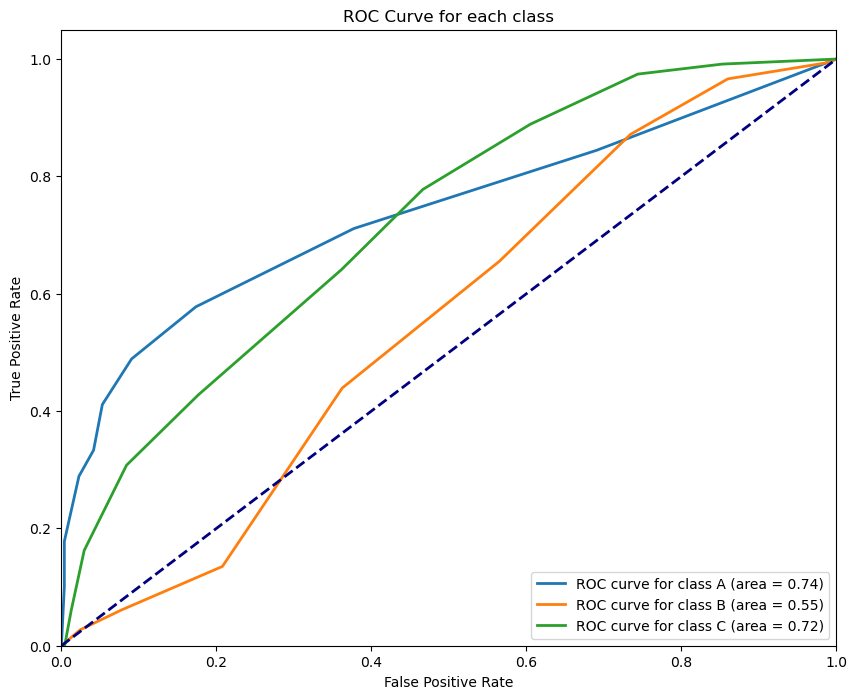

In [32]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, predictions_first_model)
precision = precision_score(y_test, predictions_first_model, average='macro')
recall = recall_score(y_test, predictions_first_model, average='macro')
f1 = f1_score(y_test, predictions_first_model, average='macro')
confusion = confusion_matrix(y_test, predictions_first_model)

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

# ROC Curve preparation
y_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = knn.predict_proba(X_test)

fpr, tpr, roc_auc = dict(), dict(), dict()
for i, class_name in enumerate(np.unique(y_test)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(np.unique(y_test)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {class_name} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()


Hyperparameter Tuning. What is the best K?

In [33]:
from sklearn.model_selection import cross_val_score

k_values = list(range(1, 21))
cv_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy')
    cv_scores.append(scores.mean())
    
    best_k = k_values[np.argmax(cv_scores)]
print(f'Best k: {best_k}')

Best k: 20


In [34]:
# Define the columns to exclude from the features
exclude_columns = [
    'IM_KEY', 'IM_DESCR', 'IM_BUYER', "IM_LAST_REC_DATE",
    'IM_UNIT_I', 'IM_UNIT_R', 'IM_UNIT_S', 'IM_TYPE',
    'IM_CLASS', 'IM_QTY', 'IM_SAFETY', "IM_MIN",'IM_MAX',"IM_STD_MAT"
]

# Prepare the features (X) by excluding the specified columns and the target (y) as 'IM_ABC'
X = abc_filtered_df.drop(columns=exclude_columns + ['IM_ABC'])
y = abc_filtered_df['IM_ABC']

In [35]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Ensure the data is contiguous in memory
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

In [36]:
# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Make predictions
predictions_second_model = knn.predict(X_test)

Model Performance Metrics:
Accuracy: 0.52
Precision: 0.55
Recall: 0.52
F1 Score: 0.52
Confusion Matrix:
[[41 32 17]
 [20 78 50]
 [ 2 49 66]]


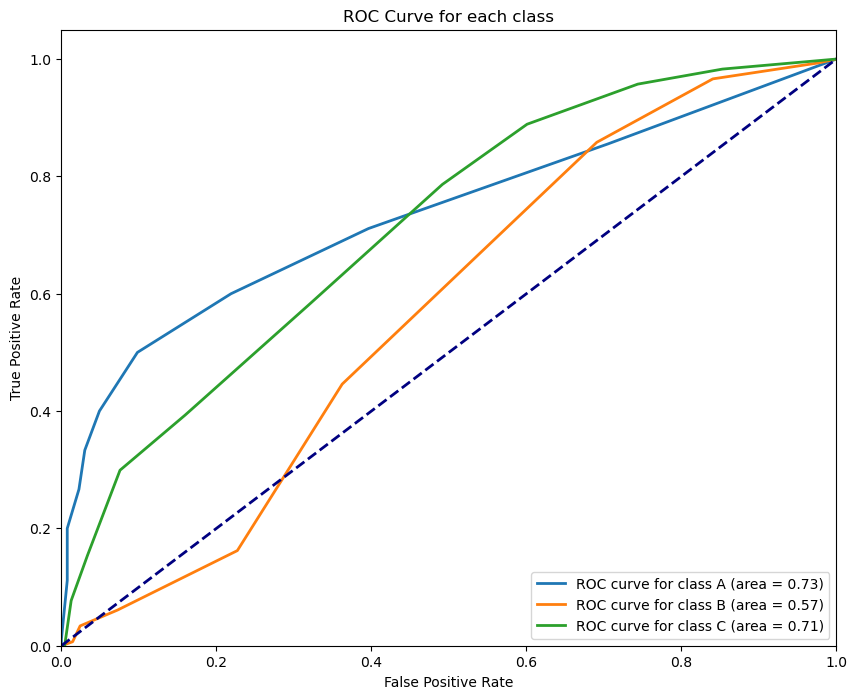

In [37]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, predictions_second_model)
precision = precision_score(y_test, predictions_second_model, average='macro')
recall = recall_score(y_test, predictions_second_model, average='macro')
f1 = f1_score(y_test, predictions_second_model, average='macro')
confusion = confusion_matrix(y_test, predictions_second_model)

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

# ROC Curve preparation
y_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = knn.predict_proba(X_test)

fpr, tpr, roc_auc = dict(), dict(), dict()
for i, class_name in enumerate(np.unique(y_test)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(np.unique(y_test)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {class_name} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()


In [38]:

# Calculate accuracy for the first model
accuracy_first_model = accuracy_score(y_test, predictions_first_model)

# Calculate accuracy for the second model
accuracy_second_model = accuracy_score(y_test, predictions_second_model)

# Compare accuracies and determine the optimal model
if accuracy_first_model > accuracy_second_model:
    optimal_model = "First Model"
    optimal_model_accuracy = accuracy_first_model
else:
    optimal_model = "Second Model"
    optimal_model_accuracy = accuracy_second_model

print(f"The optimal model is the {optimal_model} with an accuracy of {optimal_model_accuracy:.2f}.")


The optimal model is the Second Model with an accuracy of 0.52.


In [39]:
# Creating the decision tree classifier
clf = DecisionTreeClassifier()

# Training the classifier on the training data
clf.fit(X_train, y_train)

# Making predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluating the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.49577464788732395


In [40]:
x = abc_filtered_df.drop(columns=exclude_columns + ['IM_ABC'])
y = abc_filtered_df['IM_ABC']

In [41]:
X3_train, X3_test, y3_train, y3_test = train_test_split(x, y, test_size=0.2, random_state=23)

decision_tree_classifier = DecisionTreeClassifier(random_state=23)
decision_tree_classifier.fit(X3_train, y3_train)

predictions3 = decision_tree_classifier.predict(X3_test)


In [42]:
accuracy = accuracy_score(y3_test, predictions3)
precision = precision_score(y3_test, predictions3, average='weighted', zero_division=1)
recall = recall_score(y3_test, predictions3, average='weighted')
f1 = f1_score(y3_test, predictions3, average='weighted')
confusion = confusion_matrix(y3_test, predictions3)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print('Confusion Matrix:')
print(confusion)

Accuracy: 49.58%
Precision: 0.49
Recall: 0.50
F1-score: 0.49
Confusion Matrix:
[[44 31 15]
 [32 62 54]
 [ 6 41 70]]


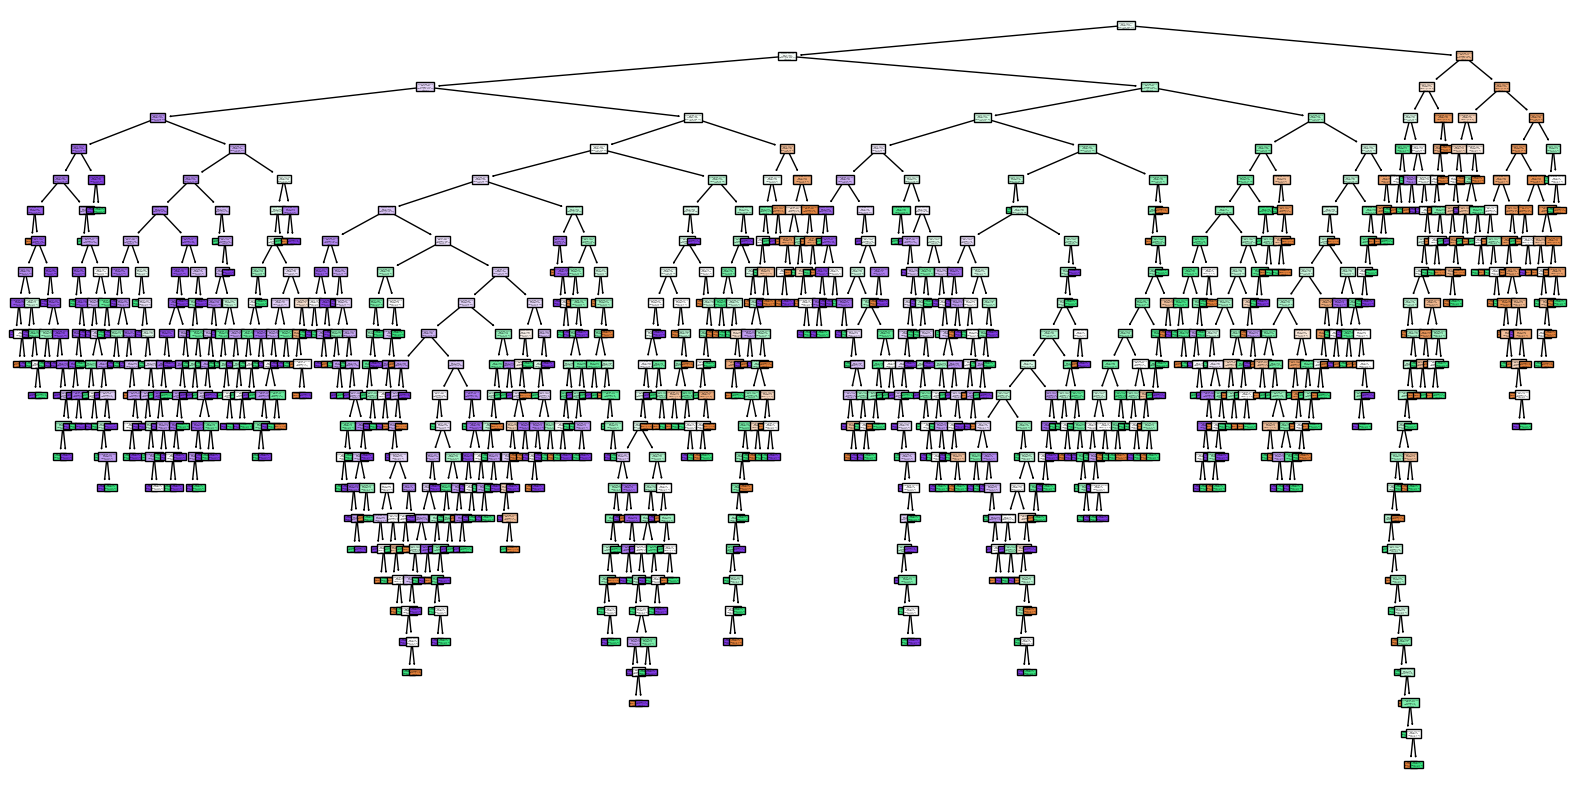

In [43]:

feature_names = list(X3_train.columns)
class_names = [str(class_label) for class_label in decision_tree_classifier.classes_]
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_classifier, filled=True, feature_names=feature_names, class_names=class_names)
plt.show()

hyperparameter tuning. What is the best P?

In [44]:

parameter_grid = {'max_depth': [3, 5, 7, 9, None]}

decision_tree_classifier = DecisionTreeClassifier(random_state=23)
grid_search = GridSearchCV(decision_tree_classifier, parameter_grid, cv=5, scoring='accuracy')

grid_search.fit(x, y)

best_depth = grid_search.best_params_['max_depth']
best_decision_tree_classifier = DecisionTreeClassifier(max_depth=best_depth, random_state=23)
best_decision_tree_classifier.fit(x, y)
print(f'Best Max Depth: {best_depth}')

Best Max Depth: 3


In [45]:
X3_train, X3_test, y3_train, y3_test = train_test_split(x, y, test_size=0.2, random_state=23)
decision_tree_classifier = DecisionTreeClassifier(max_depth=5, random_state=23)
decision_tree_classifier.fit(X3_train, y3_train)
predictions3 = decision_tree_classifier.predict(X3_test)

In [46]:
accuracy = accuracy_score(y3_test, predictions3)
precision = precision_score(y3_test, predictions3, average='weighted', zero_division=1)
recall = recall_score(y3_test, predictions3, average='weighted')
f1 = f1_score(y3_test, predictions3, average='weighted')
confusion = confusion_matrix(y3_test, predictions3)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print('Confusion Matrix:')
print(confusion)

Accuracy: 52.68%
Precision: 0.56
Recall: 0.53
F1-score: 0.53
Confusion Matrix:
[[35 43 12]
 [11 82 55]
 [ 1 46 70]]


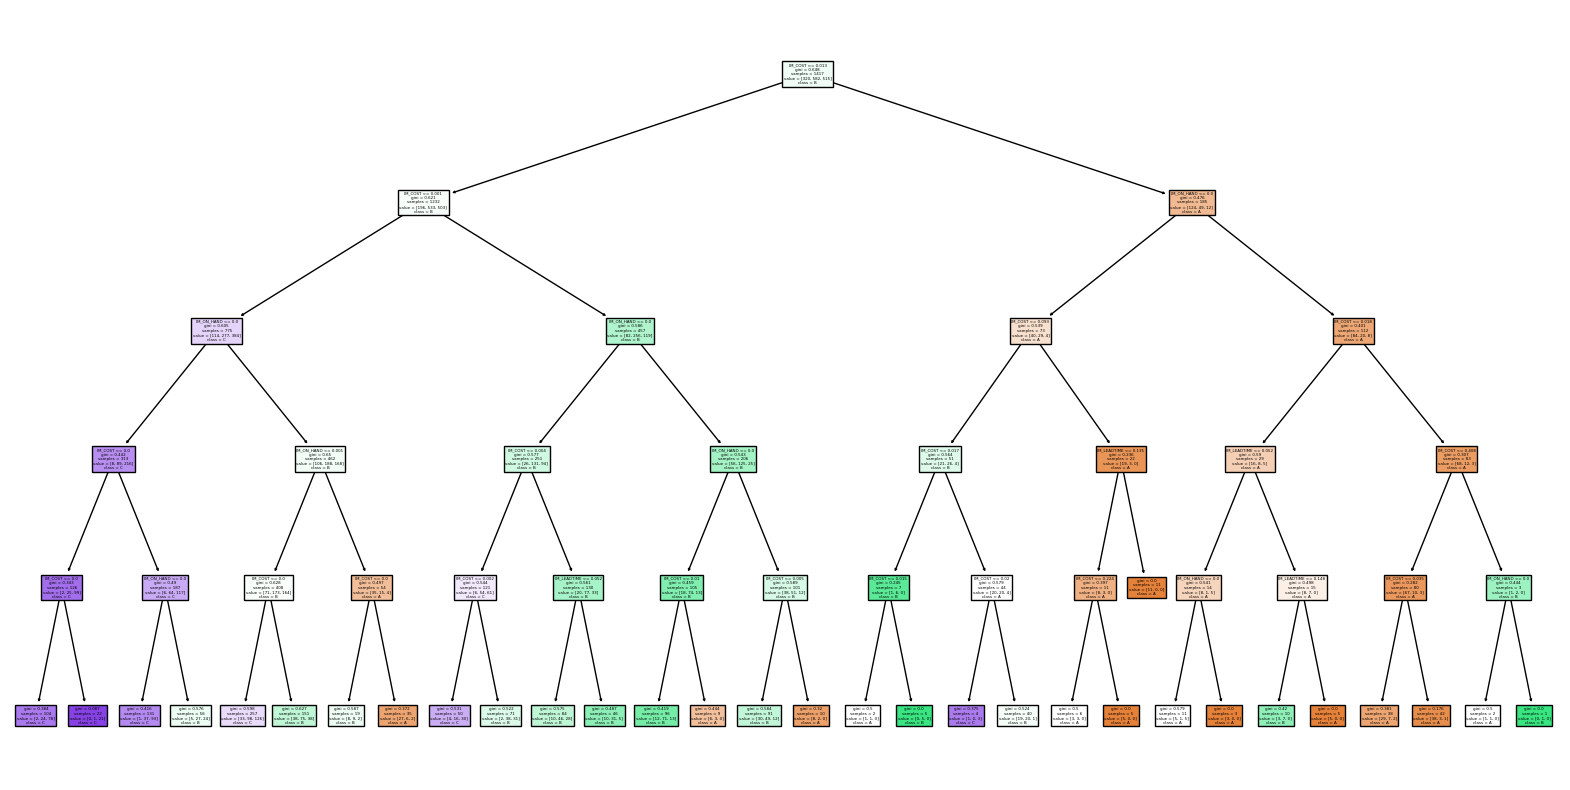

In [47]:
feature_names = list(X3_train.columns)
class_names = [str(class_label) for class_label in decision_tree_classifier.classes_]
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_classifier, filled=True, feature_names=feature_names, class_names=class_names)
plt.show()

Random Forest Regressor

In [48]:

# Define the columns to exclude from the features
exclude_columns = [
    'IM_KEY', 'IM_DESCR', 'IM_BUYER', "IM_LAST_REC_DATE",
    'IM_UNIT_I', 'IM_UNIT_R', 'IM_UNIT_S', 'IM_TYPE',
    'IM_CLASS', 'IM_QTY', 'IM_SAFETY'
]

# Prepare the features (X) by excluding the specified columns and the target (y) as 'IM_ABC'
X = abc_filtered_df.drop(columns=exclude_columns + ['IM_ABC'])
y = abc_filtered_df['IM_ABC']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X4_train, X4_test, y4_train, y4_test = train_test_split(X, y_encoded, test_size=0.2, random_state=23)

random_forest_regressor = RandomForestRegressor(random_state=23)
random_forest_regressor.fit(X4_train, y4_train)

predictions4 = random_forest_regressor.predict(X4_test)

In [49]:


mse = mean_squared_error(y4_test, predictions4)
r2 = r2_score(y4_test, predictions4)

print("Performance Metrics for Random Forest Regressor :")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Performance Metrics for Random Forest Regressor :
Mean Squared Error (MSE): 0.41
R-squared (R2) Score: 0.28


Logistic Model

In [50]:

X = abc_filtered_df.drop(columns=exclude_columns + ['IM_ABC'])
y = abc_filtered_df['IM_ABC']


X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=23)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X2_train, y2_train)
predictions2 = logreg.predict(X2_test)

In [51]:
accuracy = accuracy_score(y2_test, predictions2)
precision = precision_score(y2_test, predictions2,average='macro')
recall = recall_score(y2_test, predictions2,average='macro')
f1 = f1_score(y2_test, predictions2,average='macro')
confusion = confusion_matrix(y2_test, predictions2)

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

Model Performance Metrics:
Accuracy: 0.45
Precision: 0.45
Recall: 0.38
F1 Score: 0.28
Confusion Matrix:
[[ 12  78   0]
 [  0 148   0]
 [  1 116   0]]


C:\Users\15146\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# Assuming inventory_df is your DataFrame and it's prepared for prediction
for idx, row in inventory_df.iterrows():
    if row['IM_ABC'] == " ":  # Checking for rows where 'IM_ABC' is empty
        # Prepare the row for prediction (ensure it matches the trained model's feature set)
        row_features = row[feature_names].values.reshape(1, -1)  # Reshape for a single sample prediction
        
        # Make a prediction for the current row
        prediction = decision_tree_classifier.predict(row_features)[0]  # [0] to get the single prediction value
        
        # Replace the ' ' value in 'IM_ABC' with the predicted value
        inventory_df.at[idx, 'IM_ABC'] = prediction

# After the loop, inventory_df's 'IM_ABC' column will have the ' ' values replaced by the model's predictions


C:\Users\15146\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\15146\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\15146\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\15146\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\15146\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\15146\anaconda3\Lib\site-packages\sklearn\base.py:4

In [53]:
 inventory_df

,IM_KEY,IM_DESCR,IM_BUYER,IM_ABC,IM_TYPE,IM_CLASS,IM_QTY,IM_LEADTIME,IM_MIN,IM_MAX,IM_ON_HAND,IM_UNIT_I,IM_UNIT_R,IM_UNIT_S,IM_STD_MAT,IM_COST,IM_LAST_REC_DATE,IM_SAFETY
1,PLN060F,M6X1.0X12MM VIS TETE FR. SS304,GY,B,2,1,0,10,0,0,8,EA,EA,EA,0.4626,0.4626,2022-07-18,0
4,GKR710A,CARTOUCHE 8135 POLY-E 10 MICR.,GY,B,2,1,0,10,0,0,1,EA,EA,EA,736.6892,736.6892,2023-10-19,0
7,SKA000X,"CYL. AMORT. GAZ 8"" - 80 #",STE,A,2,1,0,10,0,0,8,EA,EA,EA,48.2432,48.2432,2024-01-24,0
8,NEE120A,1-1/2 TUYAU SS304L SCH 10,GY,A,2,1,0,10,0,0,138,IN,FT,IN,0.7736,0.7736,2023-11-29,0
9,FCF217E,"PIGNON SIMPLE 17DXRC40X1-3/8""",STE,B,2,1,0,10,0,0,4,EA,EA,EA,4.0596,4.0596,2023-11-13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4251,ALH060A,HSS ALUMINIUM 6061-T6 2X2X3/16,DAN,B,2,1,0,5,0,0,26,IN,LB,IN,0.5377,0.5377,2023-05-16,0
4252,SZA000E,SCELLANT A TUYAU METAL VISSÉ,STE,B,2,1,0,5,0,0,2,EA,EA,EA,24.1842,24.1842,2023-05-05,0
4253,LGT998Z,STAR-DELTA KIT DE CONNECTION,STE,B,2,1,0,5,0,0,1,EA,EA,EA,222.4100,222.4100,2024-01-09,0
4254,LDT370E,"MOTOR BREAKER, 3-PH, 30-40A",STE,B,2,1,0,5,0,0,1,EA,EA,EA,133.7934,133.7934,2024-01-26,0


In [54]:
# Define the values to look for
values_to_check = ['A', 'B', 'C']

# Count the number of rows where 'IM_ABC' is 'A', 'B', 'C'
rows_with_abc_or_d = inventory_df['IM_ABC'].isin(values_to_check).sum()

rows_with_abc_or_d

3369

In [55]:
# Count the number of unique values in the 'IM_ABC' column
num_unique_values_im_abc = inventory_df['IM_ABC'].unique()

num_unique_values_im_abc

array(['B', 'A', 'C'], dtype=object)

In [56]:
# Count the number of unique values in the 'IM_ABC' column
num_unique_values_im_abc = inventory_df['IM_ABC'].nunique()

num_unique_values_im_abc

3

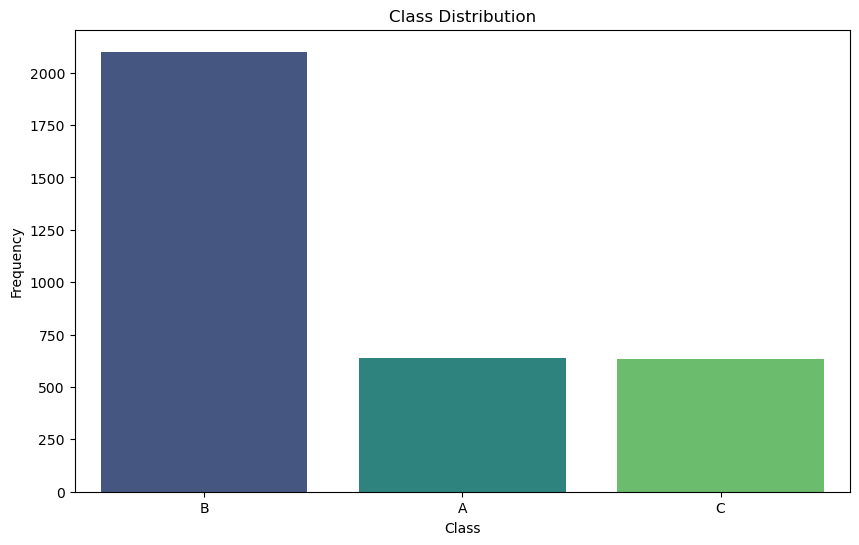

In [57]:
# Replace 'Target' with your actual target column name
class_counts = inventory_df['IM_ABC'].value_counts()

# Plotting the class distribution as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()
